In [1]:
import cv2
import torch
import triton
from triton import language as tl
from matplotlib import pyplot as plt

In [2]:
image_path = "./Irish Setter Image.jpeg"

In [3]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

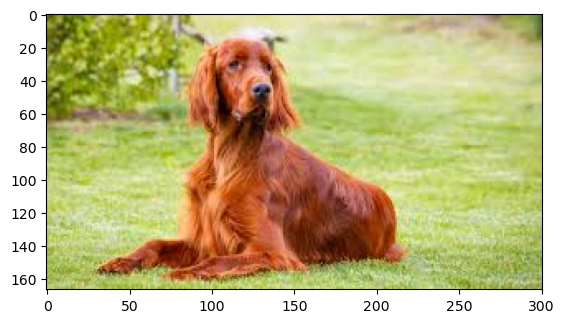

In [4]:
plt.imshow(img)

In [5]:
img = torch.tensor(img, device="cuda:0", dtype=torch.float32)

In [6]:
img.shape

torch.Size([167, 301, 3])

In [7]:
def gray_scale_torch(x: torch.Tensor) -> torch.Tensor:
    R = x[:,:,0]
    G = x[:,:,1]
    B = x[:,:,2]
    return 0.299 * R + 0.587 * G + 0.114 * B

In [8]:
img_gray_scale = gray_scale_torch(img)

In [9]:
img_gray_scale

tensor([[152.3220, 110.3220,  81.7780,  ..., 112.1320, 100.5940,  93.0670],
        [132.3050,  97.0770,  72.3310,  ..., 111.0610,  99.5940,  90.7680],
        [ 93.1570,  84.4020,  77.9460,  ..., 109.0610,  97.8220,  88.8820],
        ...,
        [182.6490, 193.1220, 192.0250,  ..., 127.8140, 149.8140, 158.0420],
        [166.7460, 187.8770, 192.1220,  ..., 138.8140, 155.8140, 149.8140],
        [193.8600, 195.1050, 185.1220,  ..., 154.1730, 170.1730, 149.8140]],
       device='cuda:0')

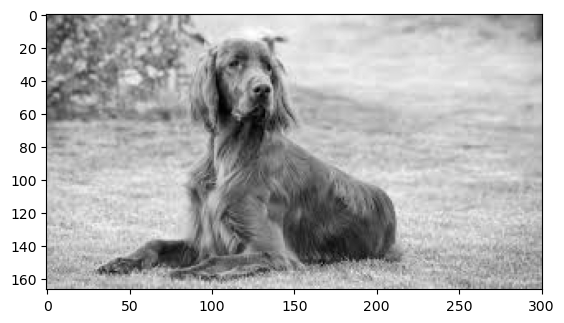

In [10]:
plt.imshow(img_gray_scale.cpu().numpy(), cmap="gray")

In [11]:
@triton.jit
def grayscale_kernel(x_ptr, output_ptr, H, W, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    offsets = pid * BLOCK_SIZE * 3 + tl.arange(0, BLOCK_SIZE) * 3
    mask = offsets < (H * W * 3)
    r = tl.load(x_ptr + offsets, mask=mask)
    g = tl.load(x_ptr + offsets + 1, mask=mask)
    b = tl.load(x_ptr + offsets + 2, mask=mask)

    gray = 0.299 * r + 0.587 * g + 0.114 * b

    tl.store(output_ptr + offsets // 3, gray, mask=mask)

In [12]:
def grayscale_triton(x: torch.Tensor) -> torch.Tensor:
    H, W = x.shape[:2]
    output = torch.empty((H, W), device=x.device, dtype=x.dtype)
    grid = lambda meta: (triton.cdiv(H * W,meta["BLOCK_SIZE"]), )
    grayscale_kernel[grid](x, output, H, W, BLOCK_SIZE=256)
    return output

In [13]:
output = grayscale_triton(img)

In [14]:
output

tensor([[152.3220, 110.3220,  81.7780,  ..., 112.1320, 100.5940,  93.0670],
        [132.3050,  97.0770,  72.3310,  ..., 111.0610,  99.5940,  90.7680],
        [ 93.1570,  84.4020,  77.9460,  ..., 109.0610,  97.8220,  88.8820],
        ...,
        [182.6490, 193.1220, 192.0250,  ..., 127.8140, 149.8140, 158.0420],
        [166.7460, 187.8770, 192.1220,  ..., 138.8140, 155.8140, 149.8140],
        [193.8600, 195.1050, 185.1220,  ..., 154.1730, 170.1730, 149.8140]],
       device='cuda:0')

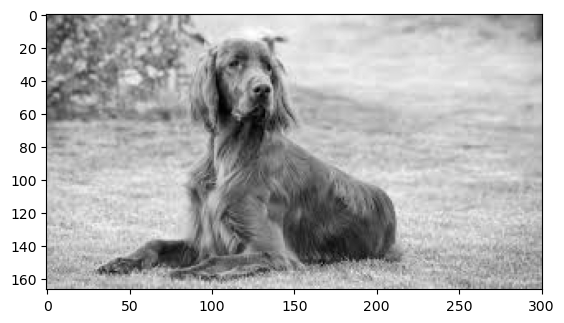

In [15]:
plt.imshow(output.cpu().numpy(), cmap="gray")